# Exploring H-2 Visa Certification Data

## Import the data

https://github.com/BuzzFeedNews/H­-2-­certification­-data/blob/master/data/processed/H­-2-certification-decisions.csv

Key columns:

visa_type: H-2B or H-2A

fy: year 2000-2016

case_status: denied, certified, partial, full, etc., condensed down to five categories

n_requested: number of workers requested for the application or row)

n_certified: number of workers certified

is_certified: boolean, connected to n_certified

certification begin date

certification end date

job title

employer state- abbreviated state name

organization flag

In [1]:
import numpy as np
import pandas as pd
pd.set_option('chained_assignment',None)
H2 = pd.read_csv("/Users/matthu24/.spyder2-py3/H-2-certification-decisions.csv", low_memory = False, encoding='ISO-8859-1')
print(H2.shape[0])

213155


##Explore

In [2]:
H2.columns


Index(['case_no', 'visa_type', 'fy', 'last_event_date', 'case_status',
       'n_requested', 'n_certified', 'is_certified',
       'certification_begin_date', 'certification_end_date', 'job_title',
       'employer_name', 'employer_state', 'employer_city',
       'employer_address_1', 'employer_address_2', 'employer_postal_code',
       'worksite_state', 'worksite_city', 'agent_name', 'organization_flag',
       'is_duplicate'],
      dtype='object')

In [3]:
H2.head(3)

,case_no,visa_type,fy,last_event_date,case_status,n_requested,n_certified,is_certified,certification_begin_date,certification_end_date,...,employer_state,employer_city,employer_address_1,employer_address_2,employer_postal_code,worksite_state,worksite_city,agent_name,organization_flag,is_duplicate
0,9455254,H-2B,2000,10/1/99,"DENIED, TEMPORARY",1,0,False,NaN,NaN,...,CA,LOS ANGELES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8222219,H-2B,2000,10/4/99,"CERTIFIED, TEMPORARY",2,2,True,NaN,NaN,...,CO,BEAVER CREEK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8222168,H-2B,2000,10/4/99,"CERTIFIED, TEMPORARY",2,2,True,NaN,NaN,...,CO,MT. CRESTED BUTTE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Plot distribution of number of applications per year

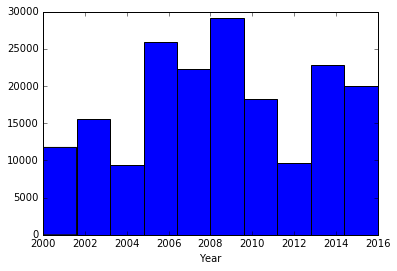

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(H2["fy"])
plt.xlabel("Year")

##Clean Data

In [5]:
#filter out duplicate rows
H2 = H2[H2["is_duplicate"] != True]
missing_values = H2.isnull().sum()
H2 = H2.dropna(subset = ['employer_state'])
print(missing_values)

H2_2011_2016 = H2[H2["fy"] >= 2011]

case_no                          0
visa_type                        0
fy                               0
last_event_date               7469
case_status                      0
n_requested                  57635
n_certified                      0
is_certified                     0
certification_begin_date     57626
certification_end_date       57631
job_title                      479
employer_name                    4
employer_state                 104
employer_city                   61
employer_address_1           43916
employer_address_2          166021
employer_postal_code         44112
worksite_state               62822
worksite_city               131118
agent_name                   38845
organization_flag           137871
is_duplicate                137871
dtype: int64


##Analysis

0. What is the breakdown for visa types H-2A vs. H-2B? How are the numbers of the two types changing per year?

          count      
visa_type  H-2A  H-2B
fy                   
2011       4941  4409
2012       5459  4211
2013       5948  4708
2014       6711  5466
2015       7552  6521
2016       1120  4813


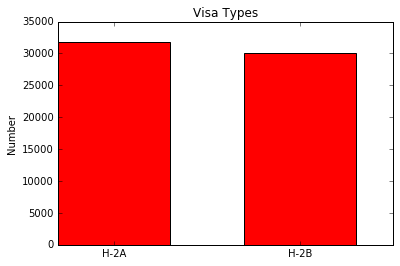

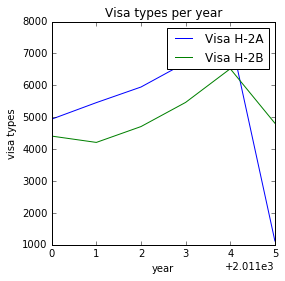

In [6]:
visa_types = H2_2011_2016["visa_type"].value_counts()

ind = np.arange(len(visa_types))
width = 0.6
plt.figure(figsize=(5,6),dpi = 20)
fig, ax = plt.subplots()
rects = ax.bar(ind,visa_types.values,width,color='r')
ax.set_xticklabels(visa_types.index)
ax.set_ylabel('Number')
ax.set_title('Visa Types')
ax.set_xticks(ind + 0.5*width)


visa_type_fy = pd.DataFrame(H2_2011_2016[["fy", "visa_type"]])
visa_type_fy['count'] = 1

visa_type_fy_pivot = pd.pivot_table(visa_type_fy, index='fy', columns=['visa_type'],aggfunc=np.sum)
print(visa_type_fy_pivot)

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(1,1,1)
ax.plot(visa_type_fy_pivot.index, visa_type_fy_pivot.values)
ax.legend(['Visa H-2A', 'Visa H-2B'])
plt.title('Visa types per year')
plt.xlabel('year')
plt.ylabel("visa types")
plt.show()

1. Examine the applications with the longest periods between certification beginning and end.  Is there one visa type that dominates these applications?

In [7]:
#change to datetime
H2_2011_2016['certification_begin_date'] = pd.to_datetime(H2_2011_2016['certification_begin_date'])
H2_2011_2016['certification_end_date'] = pd.to_datetime(H2_2011_2016['certification_end_date'])

#create new 2011-2016 dataframe
certification_period_total = pd.DataFrame(H2_2011_2016[['fy', 'visa_type', 
                                                           'certification_begin_date', 'certification_end_date', 
                                                            'employer_state', "n_certified", "is_certified", "job_title"]])

#compute period length from certification end and begin date
certification_period_total["period_length"] = abs(certification_period_total['certification_end_date'] \
                                            - certification_period_total['certification_begin_date'])

#Grab the 100 applications with longest certification period length:
#sort DF according to period length in descending order, than grab the first 100 rows
top_100_cert_period_requested = certification_period_total.sort_values("period_length",ascending = False).iloc[:100,:]

#what visa types were the longest periods?
LongPeriod_Visa_types = top_100_cert_period_requested["visa_type"].value_counts()
print(LongPeriod_Visa_types)
print(top_100_cert_period_requested.head(5))

H-2B    97
H-2A     3
Name: visa_type, dtype: int64
          fy visa_type certification_begin_date certification_end_date  \
153293  2012      H-2B               2001-02-28             2012-12-20   
140480  2011      H-2B               2001-01-15             2011-11-15   
183456  2014      H-2B               2014-07-07             2025-01-01   
209251  2016      H-2B               2015-10-22             2025-10-10   
209258  2016      H-2B               2015-10-22             2025-10-10   

       employer_state  n_certified is_certified  \
153293             NJ           14         True   
140480             CA           30         True   
183456             NV            0        False   
209251             IL            0        False   
209258             IL            0        False   

                            job_title  period_length  
153293             LABORER, LANDSCAPE      4313 days  
140480  RECREATION FACILITY ATTENDANT      3956 days  
183456      REPAIR/SERVICE TECH

The longest certification periods can span up to 4313 days.

2. Examine case_status column: Condense the 20 + categories to six summarizing categories

In [8]:
orig_case_status = H2_2011_2016["case_status"].value_counts()
print(orig_case_status)
#replace all case statuses with six main categories

Certified = ['CERTIFIED - FULL','CERTIFIED','CERTIFIED, TEMPORARY','DETERMINATION ISSUED - CERTIFICATION','CERTIFICATION']
Partial = ['PARTIAL CERTIFIED','CERTIFIED - PARTIAL','PARTIAL CERTIFICATION','DETERMINATION ISSUED - PARTIAL CERTIFICATION']
Denied = ['DENIED','DENIED, TEMPORARY','DETERMINATION ISSUED - DENIED','REDUCTION IN RECRUITMENT DENIED','NOF ISSUED','INCOMPLETE']
In_progress = ['RECEIVED REGIONAL OFFICE','RECEIVED','REMAND TO SWA','REMAND ISSUED TO EMPLOYER','REMAND ISSUED TO STATE','FINAL REVIEW','DATA REVIEW','RETURNED BY EMP AFTER REMAND','MODIFICATION']
Withdrawn = ['WITHDRAWN','DETERMINATION ISSUED - WITHDRAWN']
Expired = ['PARTIAL CERTIFICATION EXPIRED','DETERMINATION ISSUED - CERTIFICATION EXPIRED','CERTIFICATION EXPIRED','DETERMINATION ISSUED - PARTIAL CERTIFICATION EXPIRED']

def new_status(status):
    if status in Certified:
        status = "Certified"
    elif status in Partial:
        status = "Partial"
    elif status in Denied:
        status = "Denied"
    elif status in In_progress:
        status = "In_progress"
    elif status in Withdrawn:
        status = "Withdrawn"
    elif status in Expired:
        status = "Expired"
    return status
    
H2_2011_2016["case_status"] = H2_2011_2016["case_status"].map(lambda x: new_status(x))
new_case_status = H2_2011_2016["case_status"].value_counts()
print(new_case_status)

CERTIFIED - FULL                                        14779
DETERMINATION ISSUED - CERTIFICATION                    13545
CERTIFICATION                                           11205
CERTIFIED                                                8166
DENIED                                                   3806
PARTIAL CERTIFIED                                        3193
WITHDRAWN                                                2165
PARTIAL CERTIFICATION                                    1957
DETERMINATION ISSUED - CERTIFICATION EXPIRED              896
CERTIFIED - PARTIAL                                       766
DETERMINATION ISSUED - DENIED                             361
CERTIFICATION EXPIRED                                     355
DETERMINATION ISSUED - WITHDRAWN                          336
DETERMINATION ISSUED - PARTIAL CERTIFICATION              212
PARTIAL CERTIFICATION EXPIRED                              84
DETERMINATION ISSUED - PARTIAL CERTIFICATION EXPIRED       33
Name: ca

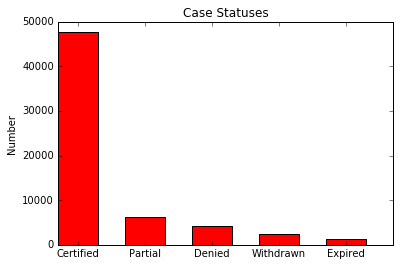

In [9]:
ind = np.arange(len(new_case_status))
width = 0.6
plt.figure(figsize=(20,20),dpi = 20)
fig, ax = plt.subplots()
rects = ax.bar(ind,new_case_status.values,width,color='r')
ax.set_xticklabels(new_case_status.index)
ax.set_ylabel('Number')
ax.set_title('Case Statuses')
ax.set_xticks(ind + 0.5*width)

3. Plot the various case status numbers as a function of time from 2011-2016.

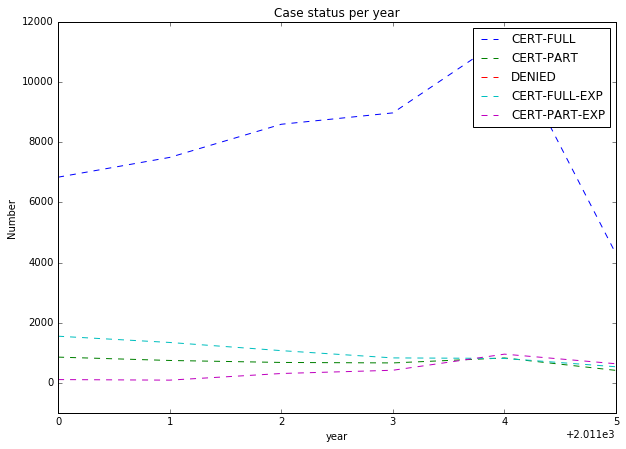

In [10]:
Case_status_fy = pd.DataFrame(H2_2011_2016[["fy","case_status"]])
Case_status_fy["count"] = 1

Case_status_fy_pivot = pd.pivot_table(Case_status_fy,index = 'fy',columns = ['case_status'],aggfunc = np.sum )

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1,1,1)
ax.plot(Case_status_fy_pivot.index, Case_status_fy_pivot.values,'--')
ax.legend(['CERT-FULL', 'CERT-PART', 'DENIED', 'CERT-FULL-EXP', 'CERT-PART-EXP', 'WITHDRAWN'])
plt.title('Case status per year')
plt.xlabel('year')
plt.ylabel("Number")
plt.ylim(-1000)
plt.show()

4. How has number of approved applications changed over time?
5. How has number of approved workers changed over time?

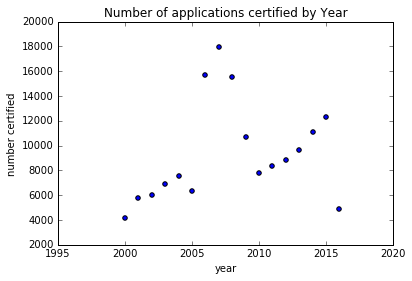

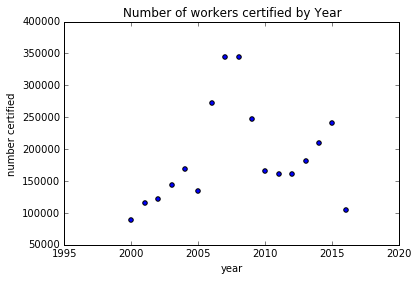

In [11]:
fy_iscertified = pd.DataFrame(H2[["fy","is_certified"]])
fy_iscertified = fy_iscertified[fy_iscertified["is_certified"] == True]
fy_iscertified_pivot = pd.pivot_table(fy_iscertified, index = "fy", aggfunc = np.sum)

fy_n_certified = pd.DataFrame(H2[["fy","n_certified"]])
fy_n_certified_pivot = pd.pivot_table(fy_n_certified,index = "fy",aggfunc = np.sum)

plt.scatter(fy_iscertified_pivot.index, fy_iscertified_pivot["is_certified"], marker = 'o')
plt.xlabel("year")
plt.ylabel("number certified")
plt.title("Number of applications certified by Year")
plt.show()

plt.scatter(fy_n_certified_pivot.index, fy_n_certified_pivot["n_certified"], marker = 'o')
plt.xlabel("year")
plt.ylabel("number certified")
plt.title("Number of workers certified by Year")
plt.show()


6. Analyze organization flag, plot bar graph of number of applications in each of the top 8 organizations.

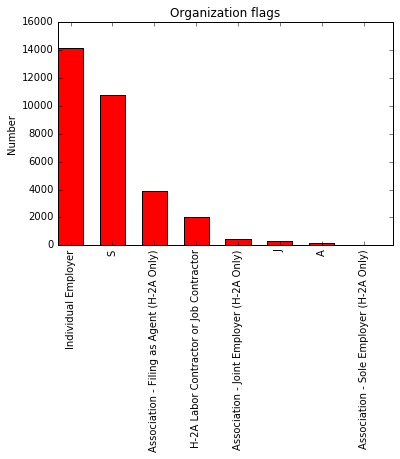

In [12]:
org_counts = H2_2011_2016["organization_flag"].value_counts()

#bar graph
import numpy
ind = np.arange(len(org_counts))
width = 0.6
plt.figure(figsize=(5,6),dpi = 20)
fig, ax = plt.subplots()
rects = ax.bar(ind,org_counts.values,width,color='r')
ax.set_xticklabels(org_counts.index,rotation = 90)
ax.set_ylabel('Number')
ax.set_title('Organization flags')
ax.set_xticks(ind + 0.5*width)
plt.show()

7.Find the states with the most number of requests:

In [16]:
request_fy = pd.DataFrame(H2[["employer_state","n_requested"]])
#pivot table for employer state and n_requests
request_fy_pivot = pd.pivot_table(request_fy,index = "employer_state",aggfunc = np.sum)
#sort in descending order and grab top 5 rows
request_fy_pivot_sort = request_fy_pivot.sort_values("n_requested",ascending = False)[:5]

#Then, compare number of requests among the states.  

print(request_fy_pivot_sort)

                n_requested
employer_state             
TX                   272625
FL                   206888
CO                   141442
LA                   139428
NC                   134951


8. Top five states with most number of requests: plot number of requests per year

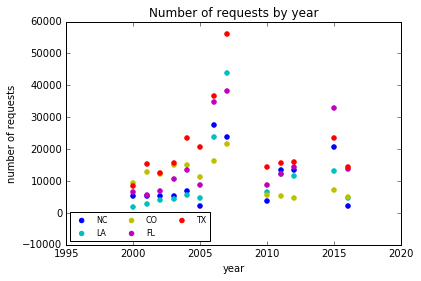

In [17]:
top_five_states_list = ["NC","LA","CO","FL","TX"]
    

Top_five_H2 = H2[H2["employer_state"].isin(top_five_states_list)]
request_fy = pd.DataFrame(Top_five_H2[["fy","n_requested","employer_state"]])
request_fy_pivot_sort = pd.pivot_table(request_fy, index='fy',columns = ["employer_state"],aggfunc=np.sum)
request_fy_pivot_sort.columns = ["CO","FL","LA","NC","TX"]
 
#plot year  vs. n-requested
#year
import matplotlib.pyplot as plt

colors = ['b','c','y','m','r']
for state in top_five_states_list:

    plt.scatter(request_fy_pivot_sort.index,request_fy_pivot_sort[state],color = colors[top_five_states_list.index(state)])
plt.legend(
           ('NC','LA','CO','FL','TX'),
           scatterpoints=1,
           loc='lower left',
           ncol=3,
           fontsize=8)
#plt.legend('NC','LA','CO','FL','TX')    
plt.title("Number of requests by year")
plt.xlabel("year")
plt.ylabel('number of requests')

plt.show()